In [1]:
# Import necessary packages. Installation in the environment must happen before. Requirements .txt not available yet.
import pandas as pd
import gdelt
import datetime
import time
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import geopandas as gpd



########################## GDELT API data loader

def c2arp_crawler(start_date, end_date, country):
    # Create GDELT API connection
    gd2 = gdelt.gdelt(version=2)

    df_iso = pd.read_csv("iso3166.csv", delimiter=';')
    country_3 = df_iso.loc[df_iso['Name'] == country, 'Code'].values[0]
    
    # Convert start and end date strings to datetime objects
    start_datetime = datetime.datetime.strptime(start_date, '%Y %m %d')
    end_datetime = datetime.datetime.strptime(end_date, '%Y %m %d')

    # Calculate the number of days between start and end dates
    delta = end_datetime - start_datetime
    num_days = delta.days + 1  # Include the end date

    print(f"Starting download for {country_3} for {num_days} days now...")
 
    # Initialize time measurement
    start_time = time.time()
    
    for i in range(num_days):
        # Calculate the current date in the loop
        current_date = start_datetime + datetime.timedelta(days=i)
        current_date_str = current_date.strftime('%Y %m %d')

        try:
            # Perform the GDELT search for the current date
            df = gd2.Search([current_date_str], table='events', coverage=True)

            results_filtered = df[
                (df['Actor1CountryCode'] == country_3) |
                (df['Actor2CountryCode'] == country_3) |
                (df['ActionGeo_FullName'].str.contains(country, na=False))
            ]

            # Load the existing CSV file or create a new DataFrame
            try:
                all_results = pd.read_csv(f'{country_3} {start_date} - {end_date}.csv', parse_dates=['SQLDATE'], low_memory=False)
            except FileNotFoundError:
                all_results = pd.DataFrame(columns=results_filtered.columns)

            # Concatenate the filtered results to the existing DataFrame
            all_results = pd.concat([all_results, results_filtered])

            # Save the DataFrame to a CSV file
            all_results.to_csv(f'{country_3} {start_date} - {end_date}.csv', index=False)

            # Print progress information
            elapsed_time = time.time() - start_time
            print(f"Processed date: {current_date_str}, {i+1}/{num_days} days done. Time taken = {elapsed_time:.2f} seconds")
            
            # Reset timer
            start_time = time.time()

        except Exception as e:
            # Handle exceptions and continue to the next date
            print(f"Error processing date {current_date_str}: {e}")
            continue

def c2arp_actors(file, country):
    # Load the previous collected datafile
    df = pd.read_csv(file, low_memory=False)
    
    # Identify each actor on country level
    actors1 = df['Actor1CountryCode'].unique().tolist()
    actors2 = df['Actor2CountryCode'].unique().tolist()
    
    # Combine the lists and remove duplicates
    actors = list(set(actors1 + actors2))
    
    # Remove the assessed country if it exists in the list
    if country in actors:
        actors.remove(country)
        
    # Create a DataFrame of all actor nations
    df_act = pd.DataFrame(actors, columns=["Actors"])
    
    # Add columns for QCto and QCfrom for each QuadClass
    for qc in range(1, 5):
        df_act[f"QC{qc}to"] = 0
        df_act[f"QC{qc}from"] = 0
    
    # Calculate QCto and QCfrom for each QuadClass for each actor
    for index, actor in df_act.iterrows():
        for qc in range(1, 5):
            # Count entries where actor is in Actor2CountryCode, country is in Actor1CountryCode, and QuadClass is qc
            qc_to_count = df[(df['Actor2CountryCode'] == actor['Actors']) & 
                             (df['Actor1CountryCode'] == country) & 
                             (df['QuadClass'] == qc)].shape[0]
            
            # Count entries where actor is in Actor1CountryCode, country is in Actor2CountryCode, and QuadClass is qc
            qc_from_count = df[(df['Actor1CountryCode'] == actor['Actors']) & 
                               (df['Actor2CountryCode'] == country) & 
                               (df['QuadClass'] == qc)].shape[0]
            
            # Update the respective columns
            df_act.at[index, f"QC{qc}to"] = qc_to_count
            df_act.at[index, f"QC{qc}from"] = qc_from_count
    
    # Calculate GS for each actor
    df_act["GS"] = 0
    for index, actor in df_act.iterrows():
        gs_sum = 0
        for qc in range(1, 5):
            # Sum GoldsteinScale values where conditions are met
            gs_sum += df[(df['Actor2CountryCode'] == actor['Actors']) & 
                         (df['Actor1CountryCode'] == country) & 
                         (df['QuadClass'] == qc)]['GoldsteinScale'].sum()
            gs_sum += df[(df['Actor1CountryCode'] == actor['Actors']) & 
                         (df['Actor2CountryCode'] == country) & 
                         (df['QuadClass'] == qc)]['GoldsteinScale'].sum()
        
        # Update the GS column
        df_act.at[index, "GS"] = gs_sum
    
    # Calculate the sum of "QCTo" and "QCFrom" for each actor
    df_act["EventSum"] = df_act[[f'QC{qc}to' for qc in range(1, 5)]].sum(axis=1) + df_act[[f'QC{qc}from' for qc in range(1, 5)]].sum(axis=1)
    
    
    df_act.to_csv(f"{country}_actors.csv")
    print("Actor analysis complete!")

def c2arp_actors_viz(file, country, start_date, end_date):

    start_date = start_date.replace(' ', '-')
    end_date = end_date.replace(' ', '-')
    daterange = start_date + ' to ' + end_date
    # Load the actors data
    df_act = pd.read_csv(file, low_memory=False, index_col=1)
    iso = pd.read_csv("iso3166.csv", sep=";")

    # Sort the DataFrame by the value in "EventSum"
    df_act_sorted = df_act.sort_values(by="EventSum", ascending=False)
    
    # Select the top 10 entries
    df_act_top10 = df_act_sorted.head(10)

    # Set up colors for QuadClasses using a modern palette
    colors = ['#D32F2F', '#F57C00', '#388E3C', '#4CAF50']
    quad_classes = ['QC4', 'QC3', 'QC2', 'QC1']
    descriptions = ['Material Conflict Action', 'Verbal Conflict Action', 'Material Cooperation Action', 'Verbal Cooperation Action']

    # Get full names from ISO dataset
    actor_names = df_act_top10.index.to_series().map(iso.set_index('Code')['Name'])
    country_name = iso[iso['Code'] == country]['Name'].values[0]
    
    # Logarithmic scaling for QuadClasses
    df_act_scaled = np.log1p(df_act_top10.drop(columns=['GS']))
    
    # Scale GS score between -10 and 10
    max_abs_gs = np.max(np.abs(df_act_top10['GS']))
    gs_scaled = (20 * df_act_top10['GS'] / max_abs_gs) if max_abs_gs != 0 else 0
    
    # Ensure positive values remain positive and negative values remain negative
    gs_scaled = np.clip(gs_scaled, -10, 10)
    
    # Plotting
    sns.set(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 17), facecolor='#002040')
    
    # First subplot: Bar plot
    ax1.set_facecolor('#002040')

    for i, actor in enumerate(df_act_scaled.index):
        # Calculate positions for bars
        y_pos = i
        total_width = np.sum(df_act_scaled.loc[actor])
        x_pos_left = 0  # Starting position for left bars
        x_pos_right = 0  # Starting position for right bars
        
        # Plot bars for QuadClasses
        for j, qc in enumerate(quad_classes):
            w_to = df_act_scaled.loc[actor, f'{qc}to']
            w_from = df_act_scaled.loc[actor, f'{qc}from']
            
            # Plot "to" bar to the right of the centerline
            ax1.barh(y_pos, w_to, left=x_pos_right, color=colors[j], alpha=1, linewidth=0)
            x_pos_right += w_to
            
            # Plot "from" bar to the left of the centerline
            x_pos_left = x_pos_left - w_from
            ax1.barh(y_pos, w_from, left=x_pos_left, color=colors[j], alpha=1, linewidth=0)

        # Plot GS score as a marker
        ax1.scatter(gs_scaled.loc[actor], y_pos, color='gold', marker='|', s=500, label=None if i > 0 else 'Goldstein Scale (scaled)')

    # Add centerline
    ax1.axvline(0, color='white', linewidth=1.5)

    # Add labels
    ax1.set_yticks(range(10))
    ax1.set_yticklabels(actor_names, fontname='Arial', fontsize=12, color='white')
    ax1.set_xlabel('Logarithmic Event Sum', fontsize=12, fontname='Arial', color='white')
    ax1.set_title(f'{country_name}\'s Top 10 International Relations Developments from {daterange}\n\nAction towards {country_name}{" " * 30}Action from {country_name}', fontsize=18, fontname='Arial', color='white')

    ax1.invert_yaxis()  # Invert y-axis to have the first actor at the top

    # Hide spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    # Tone down grid lines
    ax1.grid(color='white', linestyle='-', linewidth=0.3)
    ax1.xaxis.grid(True)
    ax1.yaxis.grid(False)

    # Remove x-axis ticks
    ax1.tick_params(axis='x', which='both', bottom=False, top=False, colors='white')
    ax1.tick_params(axis='y', which='both', left=False, right=False)

   # Add legend with descriptions
    patches = [plt.Rectangle((0,0),1,1, color=colors[i], ec="none") for i in range(len(colors))]
    descriptions_with_gs = descriptions + ['Scaled Cumulative Goldstein Score']
    descriptions_with_gs_full = ['Actions of physical disagreement', 
                                 'Actions of verbal disagreement', 
                                 'Actions of physical cooperation', 
                                 'Actions of verbal cooperation'] + ['Scaled Cumulative Goldstein Score\nindicating the overall impact']
    patches.append(plt.Line2D([0], [0], marker='|', color='gold', markersize=10, linestyle='None', label='Goldstein Scale (scaled)'))
    legend = ax1.legend(patches, descriptions_with_gs_full, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, labelcolor='white', facecolor='#002040')

    for text in legend.get_texts():
        text.set_color("white")
        text.set_ha('left')

    # Set equal limits for the x-axis
    ax1.set_xlim(-max(ax1.get_xlim()[1], abs(ax1.get_xlim()[0])), max(ax1.get_xlim()[1], abs(ax1.get_xlim()[0])))

    # Second subplot: World map
    ax2 = plt.subplot(212, projection=ccrs.PlateCarree())
    ax2.set_global()

    # Add geographical features
    ax2.add_feature(cfeature.LAND, facecolor='lightgray')
    ax2.add_feature(cfeature.OCEAN, facecolor='#ADD8E6')
    ax2.add_feature(cfeature.COASTLINE)
    ax2.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')

    # Plot the specified country in blue
    shape_reader = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
    for country_record in shpreader.Reader(shape_reader).records():
        if country_record.attributes['ADM0_A3'] == country:
            ax2.add_geometries([country_record.geometry], ccrs.PlateCarree(), facecolor='#000080', edgecolor='#00BFFF')

    # Highlight countries based on Goldstein scale
    for i, actor in enumerate(df_act_top10.index):
        actor_code = actor
        if gs_scaled.loc[actor] > 0:
            color = 'green'
            ecolor = '#39FF14'
        elif gs_scaled.loc[actor] < 0:
            color = '#FF073A'
            ecolor = '#FF073A'
        else:
            continue

        for country_record in shpreader.Reader(shape_reader).records():
            if country_record.attributes['ADM0_A3'] == actor_code:
                ax2.add_geometries([country_record.geometry], ccrs.PlateCarree(), facecolor=color, edgecolor=ecolor, alpha=0.6)

    ax2.set_title('')

     # Add legend to the map subplot with customized colors and font color
    legend_labels = {'base': f'{country_name}', 'green': 'Relations improved', 'red': 'Relations deteriorated', }
    legend_handles = [
        plt.Line2D([0], [0], marker='s', color='#00BFFF', markerfacecolor='#000080', markersize=10, label=f'{country_name}'),  # Blue marker
        plt.Line2D([0], [0], marker='s', color='#39FF14', markerfacecolor='green', markersize=10, label='Relations improved'),  # Green marker
        plt.Line2D([0], [0], marker='s', color='#FF073A', markerfacecolor='red', markersize=10, label='Relations deteriorated')  # Red marker

    ]
    legend = ax2.legend(handles=legend_handles, labels=legend_labels.values(), loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    plt.setp(legend.get_texts(), color='white')  # Set font color to white

    # Set legend box color to match background
    legend.get_frame().set_facecolor('#002040')  # Set legend box color to dark blue
    legend.get_frame().set_edgecolor('#002040')  # Set legend box edge color dark blue

    # Add information regarding Cartopy to the license box
    cr = "\u00A9"
    license_text = ("Analysis created with C²ARP\n"
                f"{cr} 2024 Swes92 / The C²ARP Project under GNU GPL 3.0\n"
                "Data Source: The GDELT Project (https://www.gdeltproject.org/)\n"
                "Visualization: Matplotlib & Seaborn, Cartopy for maps\n"
                "Image licensed under CC BY-SA 4.0\n"
                )
    plt.figtext(0.99, 0.01, license_text, horizontalalignment='right', fontsize=8, color='white')

    # Show plot
    plt.tight_layout()
    plt.show()


def c2arp_domestic(file, country):
    # Specify the columns you want to import as strings
    columns_as_string = ['EventCode', 'EventBaseCode', 'EventRootCode']

    # Create a dictionary for dtype with all specified columns as strings
    dtype_dict = {col: str for col in columns_as_string}

    df = pd.read_csv(file, low_memory=False, dtype=dtype_dict)

    ## Filter Section for 4 Sub-Dfs ############################# Adjustable ###############################
    # Include further filters for the protests events later!
    df_protest = df[df["EventRootCode"] == '14'].copy()
    df_protest.dropna(subset=["ActionGeo_Lat", "ActionGeo_Long"], inplace=True)


    df_violence = df[(df["EventRootCode"] == '18') | (df["EventRootCode"] == '19')].copy()
    df_violence.dropna(subset=["ActionGeo_Lat", "ActionGeo_Long"], inplace=True)

    
    df_police = df[(df["EventRootCode"] == '15') | (df["EventRootCode"] == '17')].copy()
    df_police.dropna(subset=["ActionGeo_Lat", "ActionGeo_Long"], inplace=True)

 
    df_placeholder = 'placeholder'
    c2arp_domestic_viz(df_protest, df_violence, df_police, df_placeholder, country)


def c2arp_domestic_viz(df1, df2, df3, df4, country):
    #to be called from the c2arp_domestic function
    population_threshold = 1000000
    scalerank_threshold=2
    # Load Natural Earth data
    countries_shapefile = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries')
    populated_places_shapefile = shpreader.natural_earth(resolution='10m', category='cultural', name='populated_places')

    # Read the shapefiles into GeoDataFrames
    countries = gpd.read_file(countries_shapefile)
    populated_places = gpd.read_file(populated_places_shapefile)
    
    # Filter the data to get the specific country by ISO abbreviation
    country_data = countries[countries['ADM0_A3'] == country]

    if country_data.empty:
        print(f"No country found with ISO abbreviation: {country}")
        return
    
    # Filter populated places based on scalerank threshold
    populated_places = populated_places[populated_places['SCALERANK'] <= scalerank_threshold]
    
    # Get the bounding box of the country
    minx, miny, maxx, maxy = country_data.total_bounds
    
    # Filter populated places to include only those within the bounding box of the country
    populated_places = populated_places.cx[minx:maxx, miny:maxy]
    
    # Create subplots
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(2, 2, figsize=(15, 17), subplot_kw={'projection': ccrs.PlateCarree()}, facecolor='#002040')
    axs = axs.ravel()

    for ax in axs:
        # Add the country geometry to the plot
        country_data.plot(ax=ax, edgecolor='black', facecolor='lightblue', alpha=0.6)
        
        # Add the filtered populated places to the plot
        populated_places.plot(ax=ax, color='black', markersize=10, marker='o', alpha=1)
        
        texts = []
        for idx, row in populated_places.iterrows():
            texts.append(ax.text(row.geometry.x, row.geometry.y, row['NAME'], fontsize=8, color='black'))


        # Set the extent to the bounding box of the country with some padding
        padding = 1  # degrees of padding around the country
        ax.set_extent([minx - padding, maxx + padding, miny - padding, maxy + padding], crs=ccrs.PlateCarree())

        # Add some context to the map
        ax.coastlines(alpha=0.6)

    # Data plotting ##############################################################
    # Plot DataFrame df1 in subplot 1
    ax = axs[0]
    ax.set_title("Protests")
    if not df1.empty:
        # Iterate through the DataFrame rows
        for index, row in df1.iterrows():
            color = 'red' if '145' in row['EventBaseCode'] else 'orange'
            ax.plot(row['ActionGeo_Long'], row['ActionGeo_Lat'], '^', color=color, markersize=6, transform=ccrs.PlateCarree())

        # Create custom legend entries

        legend_elements = [
            Line2D([0], [0], marker='^', color='w', markerfacecolor='orange', markersize=8, label='General Protests'),
            Line2D([0], [0], marker='^', color='w', markerfacecolor='red', markersize=8, label='Violent Protests')
        ]
        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.070), ncol=2, fancybox=True, shadow=True)

    # Plot DataFrame df2 in subplot 2
    ax = axs[1]
    ax.set_title("Violence")
    if not df2.empty:
         # Iterate through the DataFrame rows
        for index, row in df2.iterrows():
            event_code = row['EventBaseCode']
            event_code4 = row['EventCode']
            if '181' in event_code:
                color = 'purple'
                marker = 's'
            elif '1821' in event_code4:
                color = 'cyan'
                marker = 'o'
            elif '1823' in event_code4 or '186' in event_code:
                color = 'black'
                marker = 'p'
        # Filter for military violence / engagements not fully refined, to many presumably false positives ######################
           # elif '183' in event_code:
            #    color = 'brown'
            #    marker = '*'
           # elif '193' in event_code or '194' in event_code:
           #     color = 'green'
          #      marker = 'D'
           # elif '195' in event_code:
           #     color = 'orange'
           #     marker = 'v'
            else:
                color = 'w'
                marker = ''
        
            ax.plot(row['ActionGeo_Long'], row['ActionGeo_Lat'], color=color, marker = marker, markersize=6, transform=ccrs.PlateCarree())


      # Create custom legend entries

        legend_elements = [
            Line2D([0], [0], marker='s', color='w', markerfacecolor='purple', markersize=8, label='Kidnapping'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', markersize=8, label='Sexual Violence'),
            Line2D([0], [0], marker='p', color='w', markerfacecolor='black', markersize=8, label='Murder'),
           # Line2D([0], [0], marker='h', color='w', markerfacecolor='brown', markersize=8, label='IED / Bombing'),
            #Line2D([0], [0], marker='D', color='w', markerfacecolor='green', markersize=8, label='Conventional Fighting'),
            #Line2D([0], [0], marker='v', color='w', markerfacecolor='orange', markersize=8, label='Airstrike'),
        ]
        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.115), ncol=2, fancybox=True, shadow=True)

    # Plot DataFrame df3 in subplot 3
    ax = axs[2]
    ax.set_title("Cyberattacks & Sabotage")
    if not df3.empty:
         # Iterate through the DataFrame rows
        for index, row in df3.iterrows():
            event_code = row['EventBaseCode']
            event_code4 = row['EventCode']
            if '176' in event_code:
                color = 'mediumspringgreen'
                marker = 'H'
            
            elif '1712' in event_code4:
                color = 'crimson'
                marker = 'D'
                
            else:
                color = 'w'
                marker = ''
        
            ax.plot(row['ActionGeo_Long'], row['ActionGeo_Lat'], color=color, marker = marker, markersize=6, transform=ccrs.PlateCarree())

      # Create custom legend entries

        legend_elements = [
            Line2D([0], [0], marker='H', color='w', markerfacecolor='mediumspringgreen', markersize=8, label='Cyberattacks'),
            Line2D([0], [0], marker='D', color='w', markerfacecolor='crimson', markersize=8, label='Sabotage / Destruction')
        ]
        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.070), ncol=2, fancybox=True, shadow=True)

    # Plot DataFrame df4 in subplot 4
    ax = axs[3]
    ax.set_title("LEO & MIL Activity")
    if not df3.empty:
         # Iterate through the DataFrame rows
        for index, row in df3.iterrows():
            event_code = row['EventBaseCode']
            event_code4 = row['EventCode']
            if '151' in event_code or '153' in event_code:
                color = 'dodgerblue'
                marker = '^'
            elif '152' in event_code or '154' in event_code:
                color = 'green'
                marker = '^'
            elif '1723' in event_code4:
                color = 'teal'
                marker = 'D'
            elif '173' in event_code:
                color = 'blue'
                marker = '.'
            else:
                color = 'w'
                marker = ''
        
            ax.plot(row['ActionGeo_Long'], row['ActionGeo_Lat'], color=color, marker = marker, markersize=6, transform=ccrs.PlateCarree())

      # Create custom legend entries

        legend_elements = [
            Line2D([0], [0], marker='^', color='w', markerfacecolor='dodgerblue', markersize=8, label='Icreased Police Activity'),
            Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=8, label='Icreased Military Activity'),
            Line2D([0], [0], marker='D', color='w', markerfacecolor='teal', markersize=8, label='Imposed Curfew'),
            Line2D([0], [0], marker='.', color='w', markerfacecolor='blue', markersize=8, label='Arrests & Detainments'),          
        ]
        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.115), ncol=2, fancybox=True, shadow=True)
    
    # Set titles for each subplot
    axs[0].set_title("Protests \n", color='white',fontsize=12)
    axs[1].set_title("Crime & Violence \n", color='white',fontsize=12)
    axs[2].set_title("Cyberattacks & Sabotage \n", color='white',fontsize=12)
    axs[3].set_title("LEO & MIL Activity \n", color='white',fontsize=12)


    # Add information regarding Cartopy to the license box
    cr = "\u00A9"
    license_text = ("Analysis created with C²ARP\n"
                f"{cr} 2024 Swes92 / The C²ARP Project under GNU GPL 3.0\n"
                "Data Source: The GDELT Project (https://www.gdeltproject.org/)\n"
                "Visualization: Matplotlib & Seaborn, Cartopy for maps\n"
                "Image licensed under CC BY-SA 4.0\n"
                )
    plt.figtext(0.9, 0.01, license_text, horizontalalignment='right', fontsize=8, color='white')

    # Show the plot
    plt.show()


here


C:\Users\Simon\.conda\envs\LIRACE\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [ ]:
c2arp_crawler('2024 04 01', '2024 04 30', 'India')

In [ ]:
c2arp_actors("IND_test.csv", 'IND')

In [ ]:
c2arp_actors_viz("IND_actors.csv", 'IND', '2024 04 01', '2024 04 30')

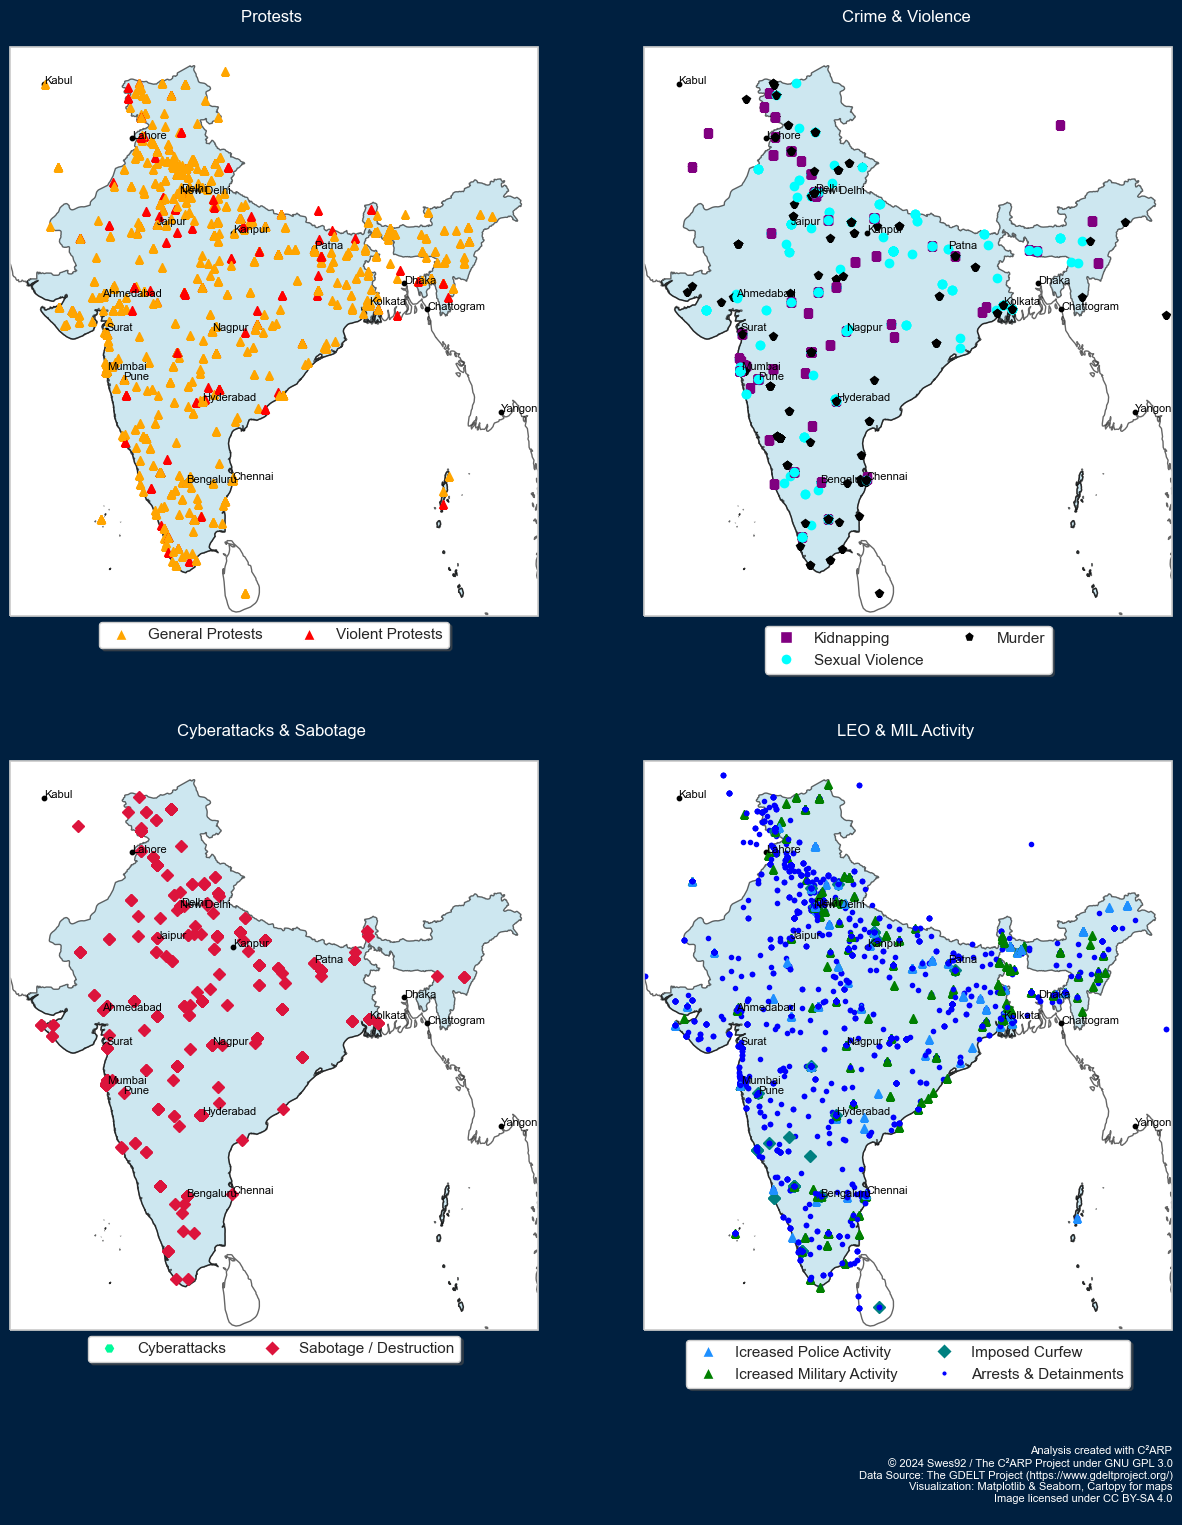

In [3]:
c2arp_domestic("IND_test.csv", 'IND')